# Part 1 Software Implementation

A Finite Impulse Response (FIR) filter is a type of digital filter used in signal processing that achieves a desired filtering response by using a finite-length impulse response. Unlike Infinite Impulse Response (IIR) filters, FIR filters have only present and past inputs, making them inherently stable and easily implementable. FIR filters are commonly used in various applications, including audio and image processing, communication systems, and digital signal processing.

To learn more about FIR filters, you can visit the following Wikipedia page: [FIR filter](https://en.wikipedia.org/wiki/Finite_impulse_response) .

The following are the main steps to be covered in part 1.

1. Demonstrate the software implementation of the application using python language and the powerful extensible library
    - Generate a complex signal data with high-frequency noise
    - Designing a lowpass FIR filter and quantization for hardware implementation
    - Apply the Filter to Signal Using lfilter and Plot the Original and Software Filtered Signals
2. Generate the input data and golden file for the AIE

## Step 1: Generate the Complex Signal Data with High-frequency Noise

Import all the Python libraries required for designing a filter. Among them, `aie_signals` and `aie_file` which provide classes for building signals, plotting signals, and converting AIE input/output data files. This is a generated signal with a fundamental frequency of 0.5 Hz, containing high-frequency harmonics at 2.5 Hz, 15.3 Hz, 16.7 Hz, and 23.45 Hz.

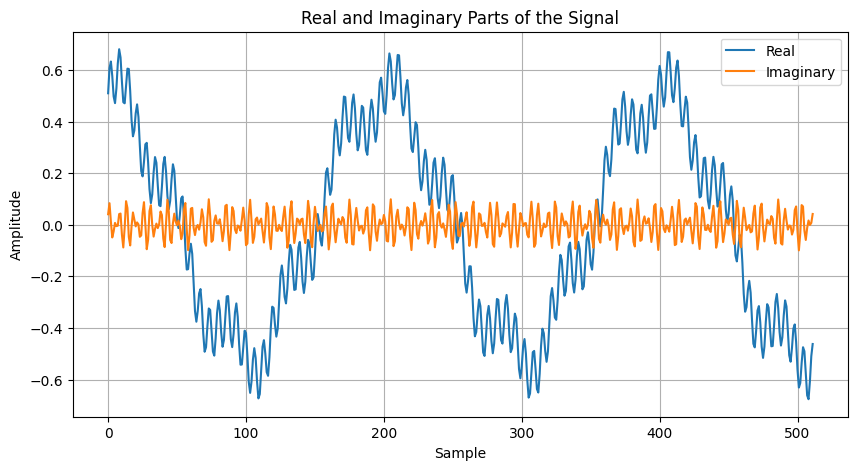

32768

In [1]:
import numpy as np
import math
from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../common/')
from aie_signals import SignalPlotter
from aie_signals import SignalGenerator
from aie_file import FileGen

sample_rate = 100.0
nsamples = 1024

# Generate and Plot the the signal
signal, time = SignalGenerator.generate_cmpx(nsamples, sample_rate)

plotter = SignalPlotter(signal)
plotter.plot_real_imaginary(512)

FileGen.vector2file_cint16(signal, '../aie/data/input.txt', scale=True)

## Step 2: Designing a Lowpass FIR Filter and Quantization for Hardware Implementation

This section explains how to design a lowpass Finite Impulse Response (FIR) filter using Python and then quantize the filter coefficients for implementation on hardware systems. FIR filters are widely used for various signal processing applications, including noise reduction and smoothing.

### 1. Nyquist Rate Calculation

The Nyquist rate is the minimum sampling rate required to accurately represent a signal without any aliasing. In this step, we calculate the Nyquist rate based on the given sample rate (sample_rate).

### 2. Setting Filter Parameters

* Desired Length (desired_length): This parameter determines the number of taps or coefficients of the FIR filter. A longer filter has better frequency resolution but requires more computational resources.

* Transition Width (width): It represents the width of the transition from the passband to the stopband, relative to the Nyquist rate. A smaller width value results in a sharper roll-off between the passband and stopband.

* Ripple in Stop Band (ripple_db): This is the desired attenuation in the stop band of the filter, specified in decibels (dB). A higher value provides better stopband attenuation but may result in a longer filter.

### 3. Computing Filter Order and Kaiser Parameter

Using the desired ripple and width values, we calculate the filter order (N) and the Kaiser parameter (beta) using the kaiserord function. The Kaiser window is chosen for designing the filter due to its excellent stopband attenuation properties.

### 4. Cutoff Frequency and Filter Coefficients

The cutoff frequency (cutoff_hz) is the frequency beyond which the filter attenuates the signal. Using the filter order and Kaiser parameter obtained in the previous step, we design a lowpass FIR filter using the firwin function with the Kaiser window.

### 5. Quantization for Hardware Implementation

In hardware systems, it is essential to represent filter coefficients with limited precision due to hardware constraints. To achieve this, we quantize the filter coefficients for AIE implementation.

* Shift Number (shift_num): This parameter represents the number of bits used for quantization. A higher shift_num results in better precision but requires more resources.

* Scaling Factor: We calculate the scaling factor to map the range of filter coefficients to the range representable by the available data type.

* Weighted Quantization: The filter coefficients are then quantized using this scaling factor to ensure they fit within the available hardware resources.

### 6. Validating Filter Coefficients

The following operation calculates the coefficients for a lowpass FIR filter with a specified cutoff frequency (10Hz), desired length(16), and transition width, using a Kaiser window and then performs weighted quantization of the coefficients to ensure a limited bit representation while maintaining the sum of the coefficients within a specified range. If the sum of the quantized filter coefficients is within the range representable by the available hardware (2<sup>15</sup> - 1). If it exceeds this range, we rescale the coefficients to fit within the hardware constraints.

compute_len = 74
filter_len = 16
lpf_coeffs array = [-0.00089151 -0.00351612 -0.00371081  0.00818791  0.04209727  0.0979466
  0.15949841  0.20038827  0.20038827  0.15949841  0.0979466   0.04209727
  0.00818791 -0.00371081 -0.00351612 -0.00089151]
coeffs_sum = 1.0
lpf_coeffs hardware = [ -29 -115 -122  268 1379 3209 5226 6566 6566 5226 3209 1379  268 -122
 -115  -29]
quantized_coeffs_sum = 32764
SRS_SHIFT = 15.0


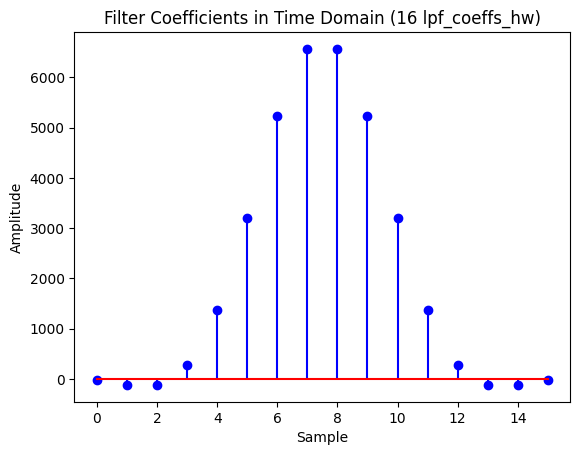

In [2]:
# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# Set the desired filter length
desired_length = 16

# The desired width of the transition from pass to stop, relative to the Nyquist rate.  We'll design the filter with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
# N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 10.0

N, beta = kaiserord(ripple_db, width)

# Use firwin with a Kaiser window to create a lowpass FIR filter.
lpf_coeffs = (firwin(desired_length, cutoff_hz/nyq_rate, window=('kaiser', beta))).astype(np.float32)

# Calculate the sum of the filter coefficients
coeffs_sum = np.sum(lpf_coeffs)

shift_num = 15
# calculate the scaling factor
scaling_factor = (2**shift_num - 1) / coeffs_sum

# Perform weighted quantization of the coefficients
lpf_coeffs_hw = np.round(lpf_coeffs * scaling_factor).astype(np.int16)

# Ensure the sum of the coefficients is less than 2^15
quantized_coeffs_sum = np.sum(lpf_coeffs_hw)
if quantized_coeffs_sum > (2**shift_num - 1):
    lpf_coeffs_hw = (lpf_coeffs_hw * (2**shift_num - 1) / quantized_coeffs_sum).astype(np.int16)

filter_len= len(lpf_coeffs_hw)

plt.stem(lpf_coeffs_hw, linefmt='b-', markerfmt='bo', basefmt='r-') 
plt.title('Filter Coefficients in Time Domain (%d lpf_coeffs_hw)' % filter_len)
plt.xlabel('Sample')
plt.ylabel('Amplitude')

print('compute_len =',N)
print('filter_len =',filter_len)
print('lpf_coeffs array =', lpf_coeffs)
print('coeffs_sum =',coeffs_sum )
print('lpf_coeffs hardware =', lpf_coeffs_hw)
print('quantized_coeffs_sum =', quantized_coeffs_sum)
SRS_SHIFT = np.round(math.log2(sum(lpf_coeffs_hw)))
print('SRS_SHIFT =',SRS_SHIFT)

## Step 3: Plot the Magnitude Response of the Filter

By plotting the magnitude response of the filter, it is clear the hardware coefficients meet the low pass filter design requirement with a cutoff frequency at 10Hz.

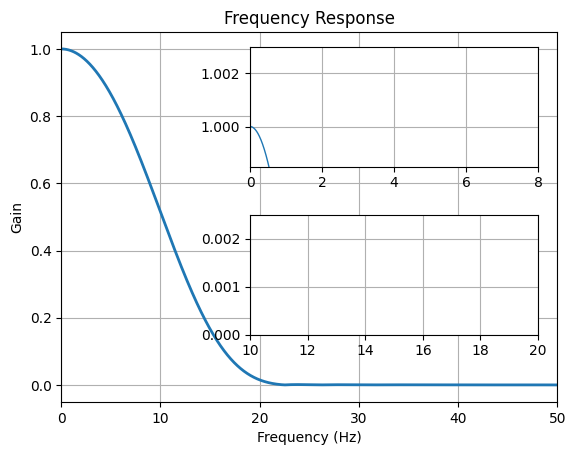

In [3]:
figure(2)
clf()
w, h = freqz(lpf_coeffs, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
xlim(0,50)
ylim(-0.05, 1.05)
grid(True)

# Upper inset plot.
ax1 = axes([0.42, 0.6, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=1)
xlim(0,8)
ylim(0.9985, 1.003)
grid(True)

# Lower inset plot
ax2 = axes([0.42, 0.25, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=1)
xlim(10.0, 20.0)
ylim(0.0, 0.0025)
grid(True)

## Step 4: Apply the Filter to Signal Using lfilter and Plot the Original and Software Filtered Signals

- Reading Input Data:

The first line reads complex input data from a file called `input.txt` using the FileGen class's `read_cmpx` method. The data is stored in the `input_data` variable, and the data is read in chunks of 1,024 samples.

- Lowpass FIR Filter Coefficients:

The filter's hardware coefficients are manually defined in the `lpf_coeffs_hw` list. These coefficients represent the impulse response of the lowpass FIR filter. The `lfilter` function from the SciPy library is used later to apply this filter to the input data.

- Applying the Filter:

The `lfilter` function filters the `input_data` using the `lpf_coeffs_hw` as the filter coefficients and 1.0 as the gain. The result is stored in the `filtered_signal` variable, which contains the filtered complex signal.

- Software (SW) Filter Output:

The `filtered_signal` is then quantized using the `np.round` function and scaled using (2 <sup>-15 </sup>) to represent the signal with reduced precision. The quantized output is stored in the sw_filtered_signal variable.

- Writing Filtered Output to a File:

The quantized filtered output is written to the `output_golden.txt` file using the FileGen class's `write_refoutput` method. The scale parameter is set to True to indicate that the data is scaled.

- Plotting the Input Signal:

The `input_data` is plotted using the SignalPlotter class's `plot_real_imaginary` method. The plot shows both the real and imaginary parts of the complex signal with a size of 512 samples.

- Plotting the Software Filtered Signal:

The `sw_filtered_signal` is plotted in the same way as the input signal, showing both the real and imaginary parts of the filtered complex signal with a size of 512 samples.

Input Signal


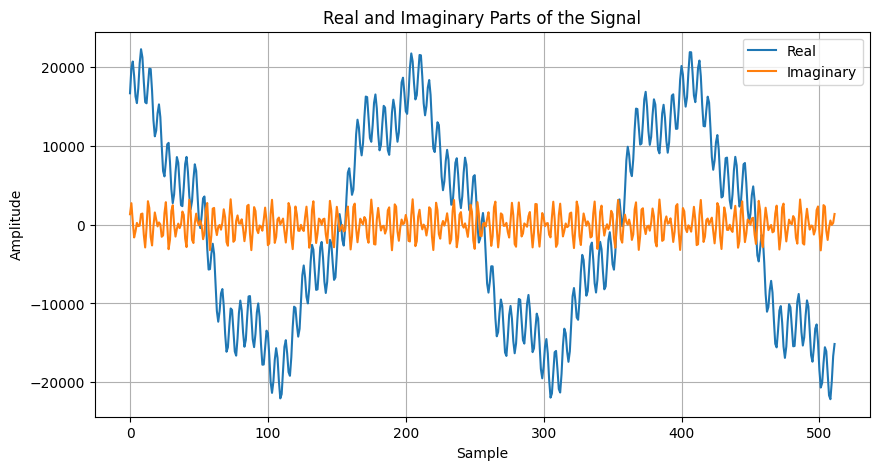

SW filtered signal


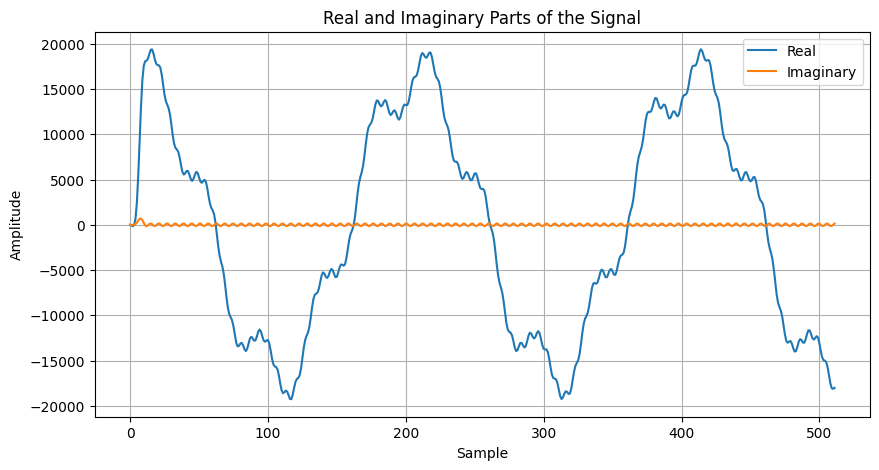

In [5]:
input_data = FileGen().read_cmpx('../aie/data/input.txt', 1024)
lpf_coeffs_hw = [ -29, -115, -122, 268, 1379, 3209, 5226, 6566, 6566, 5226, 3209, 1379,  268, -122, -115, -29]

filtered_signal = lfilter(lpf_coeffs_hw, 1.0, input_data)
sw_filtered_signal = np.round(filtered_signal * (2 ** -15))

FileGen.write_refoutput(sw_filtered_signal, '../aie/data/output_golden.txt', scale=True)

print("Input Signal")
plotter = SignalPlotter(input_data)
plotter.plot_real_imaginary(512)


print("SW filtered signal")
plotter = SignalPlotter(sw_filtered_signal)
plotter.plot_real_imaginary(512)

-------------

 

<center>

 

Copyright&copy; 2023 AMD, Inc

 

SPDX-License-Identifier: MIT

 

</center>